매주 월수금 줌회의 진행

*   각 조원들 코드 및 구조 설명
*   결과물과 에러 사항 반영 후 일주일 간격으로 로그 업데이트



# 11/16(월)

*   개괄적인 이미지 전처리 과정 구축
*   tf.keras.preprocessing.image_dataset_from_directory 함수 사용, 이미지 type은 BatchDataset
*   이미지 전처리에 집중하기 위해 합성곱 신경망 층은 기본 모델로만 설정(Sequential 코드 확인) -> 최대한 preprocessing만으로 정확도를 높인 다음에 건드리자!
*   이전에 model.fit을 실행할 때 있어 모델이 돌아가지 않는 오류 -> .numpy()함수를 통해 numpy ndarray 타입으로 바꿔서 불러오면 image_batch가 numpy로 바뀔 수 있음. 하지만 train_ds는 그대로 batchdataset



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.models import Model
from PIL import Image

data_dir = "/content/drive/My Drive/Parrot/datasets/train"

In [ ]:
#배치사이즈는 32, 이미지 크기(높이X길이)는 100X100에서 시작
batch_size = 32
size = 100

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory= data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  labels='inferred',
  label_mode='categorical',
  image_size=(size,size),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory= data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  labels='inferred',
  label_mode='categorical',
  image_size=(size,size),
  batch_size=batch_size)

Found 11248 files belonging to 9 classes.
Using 8999 files for training.
Found 11248 files belonging to 9 classes.
Using 2249 files for validation.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_names = train_ds.class_names
print(class_names)

['bart', 'charles_montgomery', 'krusty', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  image_batch.numpy()
  labels_batch.numpy()
  break

(32, 100, 100, 3)
(32, 9)


In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.99239224


(32, 100, 100, 3)
(32, 9)


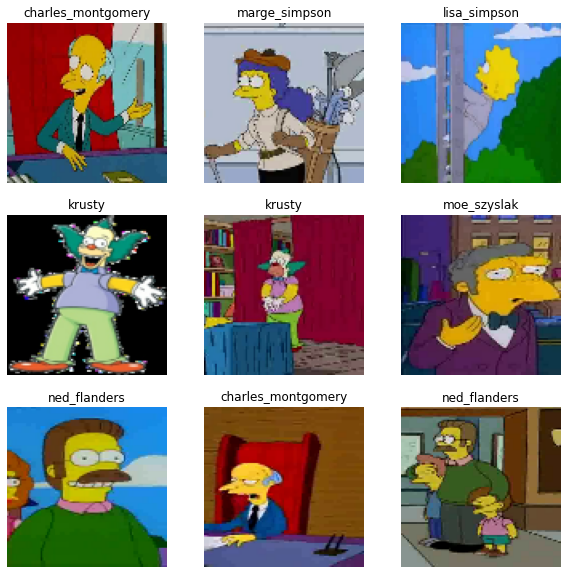

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(images.shape)
  print(labels.shape)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = 0;
    for j in labels[i]:
        if j == 1:
            break
        label = label+1;
    plt.title(class_names[label])
    plt.axis("off")

In [ ]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(size, size, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0

In [ ]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
282/282 [==============================] - ETA: 0s - loss: 2.0121 - accuracy: 0.3553 

In [ ]:
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

In [ ]:
print("CNN fitting")
acc_loss_plot(history)

# 11/18(수)

*   조원 각자 기본 모델에서 여러가지 시도해봄
*   이미지 사이즈나 배치사이즈는 기본 설정을 유지해 새로 도입한 방법의 효용성만 테스트 해봄
*   data load https://www.tensorflow.org/tutorials/images/classification
*   data augmentation https://www.tensorflow.org/tutorials/images/data_augmentation



1. Data augmentation의 사용 - 뒤집기, 돌리기, 줌인 등등
2. 전이 학습의 사용 : 전이학습이란 이미지넷과 같이 아주 큰 데이터셋에 훈련된 모델의 가중치를 가지고 와서 우리가 해결하고자 하는 과제에 맞게 재보정해서 사용하는 것 = 비교적 적은 수의 데이터를 가지고도 효과적으로 모델 훈련이 가능

전이학습
https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/transfer_learning.ipynb#scrollTo=O1p0OJBR6dOT

In [ ]:
data_augmentation = keras.Sequential(
  [ layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(size, size, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomWidth(0.1),
    layers.experimental.preprocessing.RandomHeight(0.1)]
    )

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image_batch)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train_ds.shuffle(SHUFFLE_BUFFER_SIZE)
validation_batches = val_ds

In [ ]:
print(train_batches)
print(validation_batches)
print(image_batch.shape)

In [ ]:
IMG_SHAPE = (size, size, 3)

# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
base_model.trainable = False

# 기본 모델 아키텍처를 살펴봅니다.
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = keras.layers.Dense(9)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
model2 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [ ]:
epochs = 10
history2 = model2.fit(train_ds, epochs=epochs, validation_data=val_ds)

In [ ]:
print("CNN fitting")
acc_loss_plot(history2)

3. Imagedatagenerator 사용

*   애초에 처음 이미지를 불러오는 과정부터 다름(preprocessing.image_dataset_from_directory 함수와 다른 체계)
*   data augmentation을 위해서는 numpy변환이 필요한데, 이전 코드에서는 .numpy()를 이용했지만 여기서는 어떻게 할것인가? ->가 맹점 / 이 단계에서는 .next()를 이용했지만 후에 발전시킴



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=0.1, 
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(size, size),
        batch_size=batch_size,
        class_mode='categorical', 
        subset = 'training')

validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(size, size),
        batch_size=batch_size,
        class_mode='categorical', 
        subset = 'validation')

train_x, train_y = train_generator.next() 
#next()함수 또한 numpy array로 바꿔주는 함수인데, 한 배치(32)만 numpy타입으로 바꿔주는 듯 하다...

In [ ]:
print(type(train_x))
print(train_x.shape)
print(train_y.shape)

In [ ]:
def draw_data(data, axis = 5): # axis = 5 => 5*5 프레임 만들어서 프린트하겠다. 
    len_data = len(data)
    size = axis**2
    random_int = np.random.randint(low=0, high=len_data, size=size)
    for i in range(0,size):
        plt.subplot(axis,axis,i+1)
        plt.imshow(data[random_int[i]], cmap=plt.get_cmap('Purples'))

    plt.show()

In [ ]:
draw_data(train_x, 3)

In [ ]:
tf.keras.backend.clear_session()

model3 = tf.keras.models.Sequential() 
 #기본모델과 같으나 Imagedatagenerator에서 rescaling을 이미 했으므로 빼준 것뿐 
model3.add(tf.keras.layers.Conv2D(32, 3, padding = "same", input_shape = (size,size,3), activation = 'relu'))
model3.add(tf.keras.layers.MaxPool2D()) 
model3.add(tf.keras.layers.Dropout(0.2))  
model3.add(tf.keras.layers.Conv2D(32, (3,3), padding = "same", activation = 'relu'))
model3.add(tf.keras.layers.MaxPool2D()) 
model3.add(tf.keras.layers.Dropout(0.2))  
model3.add(tf.keras.layers.Flatten()) 
model3.add(tf.keras.layers.Dense(64, activation = 'relu'))
model3.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))

model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model3.summary()

In [ ]:
history3 = model3.fit_generator(train_generator, validation_data = validation_generator,epochs = 10, verbose=1)

In [ ]:
print("CNN fitting")
acc_loss_plot(history3)

# 11/20(금)


*   수요일까지의 결과를 보면, 조건들을 다 고정시켰을 때 Imagedatagenerator로 불러오면 시간이 훨씬 빠름(세션이 자꾸 다운되어서 다시 돌릴때마다 결과가 바뀌긴 하지만, 결과 처음 냈을 때 image_dataset_from_directory는 첫 에포크 불러오는데 1000초가 넘게 걸렸음 vs datagen은 에포크 당 59초)
*   그렇다면 한 배치뿐만 아니라 전체를 numpy로 불러올 수 있는 방법은 없을까?
 -> 배치사이즈를 11248(파일 전체크기)로 바꾸고 next()를 적용시키면 된다!!



1. 배치사이즈 11248로 바꾸고 조건을 수정함

*   사이즈 128 이상은 세션이 다운됨.... whyrano..... -> 다른 조건 다 고정시키고 사이즈만 늘리니까 오히려 정확도가 감소함
*   에포크를 20으로 늘려봄



In [ ]:
size = 128

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=0.1, 
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   validation_split = 0.2) 
#validation split으로 하여금 바로 train_ds, val_ds 나눠주도록

train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size = (size, size),
        batch_size=11248,
        class_mode='categorical'
        )

train_x, train_y = train_generator.next()  
# train_generator에서 batch_size = 11248로 바꾸고 next 함수 쓰면 전체 numpy array로 바뀜

In [ ]:
print(type(train_x))
print(train_x.shape)
print(train_y.shape)

In [ ]:
tf.keras.backend.clear_session()

model4 = Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu', input_shape = (size,size,3)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model4.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model4.summary()

In [ ]:
history4 = model4.fit(train_x, train_y, validation_split=0.2, epochs = 20, batch_size=32, verbose=1)

In [ ]:
print("CNN fitting")
acc_loss_plot(history4)